Info-284 Group exam

Libraries used: Pandas, Matplotlib, NumPy, Scikit-learn, mglearn

## Table of Contents

1. [Introduction](#introduction)
2. [Preprocessing](#preprocessing)
    - [Overview](#overview)
        * [Feature selection](#feature-selection)
            + [Species](#species)
            + [Equipments](#equipments)
            + [Gross weight of catch](#gross-weight-of-catch)
            + [Boat information](#boat-information)
            + [Location of trip](#location-of-trip)
        * [Hovedart FAO](#hovedart-fao)
        * [Lengdegruppe](#lengdegruppe)
        * [Redskap FAO](#redskap-fao)
        * [Rundvekt](#rundvekt)
        * [Startområde](#startområde)
3. [Supervised Learning](#supervised-learning)
    - [Picking the Machine Learning Models](#picking-the-machine-learning-models)
    - [Our Choices](#our-choices)
    - [Transforming Dataset](#transforming-dataset)
        * [Target Variable](#target-variable)
        * [Changing Categorical Data into Numeric Data](#changing-categorical-data-into-numeric-data)
        * [Train Test Split](#train-test-split)
        * [Scaling "Rundvekt"](#scaling-rundvekt)
    - [Implementation and Evaluation](#implementation-and-evaluation)
        * [Logistic Regression](#logistic-regression)
        * [Gradient Boosted Regression Trees](#gradient-boosted-regression-trees)
        * [Neural network](#neural-network)
4. [Unsupervised Learning](#unsupervised-learning)
    - [Preprocessing for Unsupervised Learning](#preprocessing-for-unsupervised-learning)
        * [Two Unsupervised Algorithms (from the textbook p.145)](#two-unsupervised-algorithms)
        * [Picking a Clustering Algorithm: Two Considerations to Pick DBSCAN as Our Algorithm (from the textbook p.168-188)](#picking-a-clustering-algorithm)
    - [Clustering with DBSCAN](#clustering-with-dbscan)
        * [Two Parameters](#two-parameters)
        * [About DBSCAN (from the textbook p.187-188)](#about-dbscan)
        * [The Influence of the Values of Parameters](#the-influence-of-the-values-of-parameters)
        * [Is the Largest Cluster Related to Bycatch?](#is-the-largest-cluster-related-to-bycatch)
5. [Summary](#summary)
6. [Sources](#sources)

## Introduction 
In this notebook, we discuss our approach to the Norwegian Directorate of Fisheries’ dataset, which we use to predict Bycatch. We define Bycatch as instances where the species caught isn’t the same as the main species. 

In [1]:
import warnings # Got an irritating warning
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows", None)
pd.set_option("float_format", "{:f}".format)

## Preprocessing

### Overview
This dataset has 45 different features and 305 434 samples, it consists of floats, integers, and strings.  Many features are similar, so we categorized them into 8 groups.
<br>
<br>
The 8 categories are as follows:
<ul>
<li>Species</li>
<li>Equipments used</li>
<li>Gross weight of catch</li>
<li>Boat information</li>
<li>Location of trip</li>
<li>Drag distance</li>
<li>Duration</li>
<li>Time</li>
</ul>

#### Feature selection
We manually selected our features by plotting data from each feature into various plots. Based on these visualizations, we selected the features we assumed were relevant. We made two datasets: one for Bycatch and another for main species only, using these datasets we could gauge the impact of each feature on our model.

In [2]:
dataset = pd.read_csv("H:\Informasjonsvitenskap\Programming\Python\Info-284\Info284_Project\Exam Task\Dataset\elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep = ";")

# Dataset where the species isn"t the same as the main-species
bycatch = dataset[dataset["Art FAO"] != dataset["Hovedart FAO"]]

# Dataset where the species is the same as the main-species
main_species = dataset[dataset["Art FAO"] == dataset["Hovedart FAO"]]

#### Species

This feature consisted of "Hovedart FAO" and "Art FAO", this feature is necessary as it´s how we identified Bycatch.

#### Equipments

To measure the relevance of equipment, we compared the distribution of equipment in the original dataset and the Bycatch dataset.

<Axes: xlabel='Redskap FAO'>

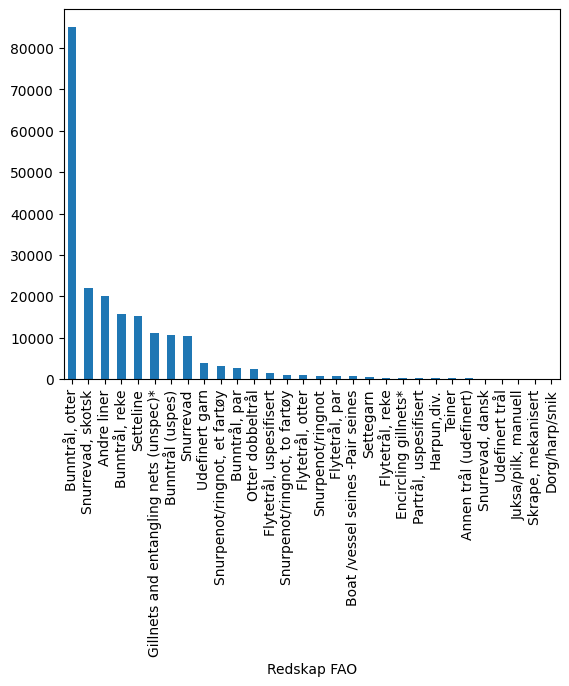

In [3]:
# A count of instances of equipment used for every Bycatch. 
count_of_equipment_used_for_only_Bycatch = bycatch.groupby(["Redskap FAO"])["Redskap FAO"].count()
count_of_equipment_used_for_only_Bycatch = count_of_equipment_used_for_only_Bycatch.sort_values(ascending=False)
count_of_equipment_used_for_only_Bycatch.plot(kind="bar")

<Axes: xlabel='Redskap FAO'>

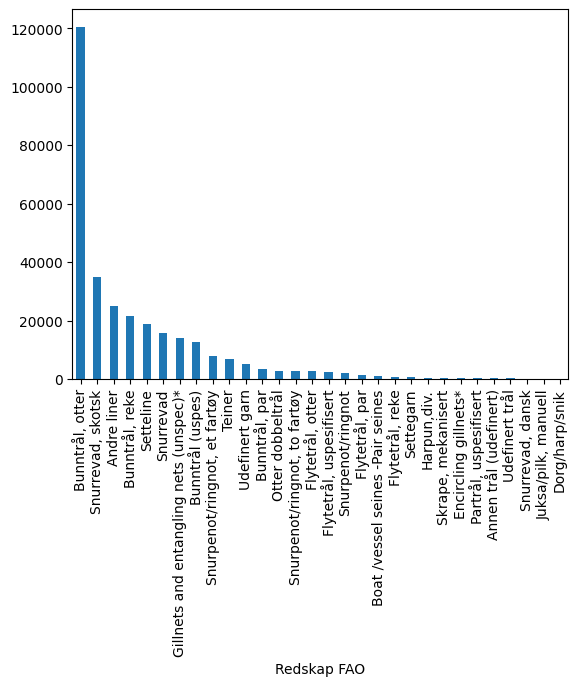

In [4]:
# A count of instances of equipment used for every species. 
count_of_equipment_used_for_original_dataset = dataset.groupby(["Redskap FAO"])["Redskap FAO"].count()
count_of_equipment_used_for_original_dataset = count_of_equipment_used_for_original_dataset.sort_values(ascending=False)
count_of_equipment_used_for_original_dataset.plot(kind="bar")

We didn't see too much of a difference here. We then checked the correlation between the most common Bycatch species caught and the equipment used to catch them.

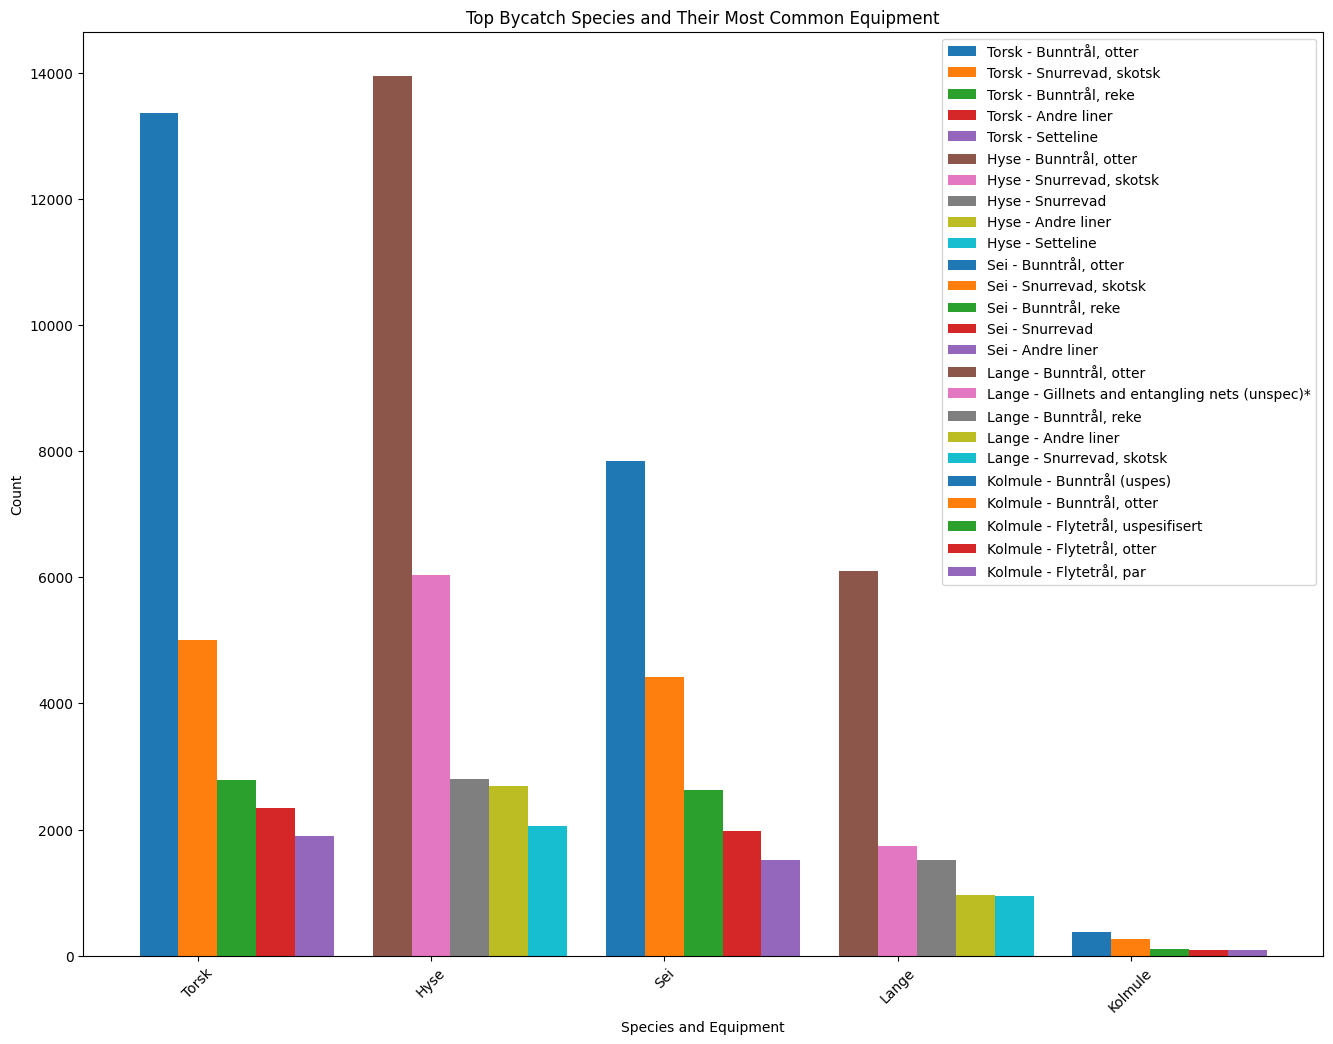

In [5]:
# Finding the most common bycatch, defined by Bycatch species with highest roundweight. 
count_of_Bycatches_for_every_main_species = bycatch.groupby(["Art FAO"])["Rundvekt"].sum()

# Top 5 species 
top_5_common_bycatch = (count_of_Bycatches_for_every_main_species.sort_values(ascending=False))[:5]
top_5_common_bycatch = list(top_5_common_bycatch.index)

fig, ax = plt.subplots(figsize=(16, 12)) 

positions = np.arange(len(top_5_common_bycatch))*3  
width = 0.5

# Finding the most common equipment used for catching each of these species
for i, species in enumerate(top_5_common_bycatch):
    species_only_dataset = bycatch[bycatch["Art FAO"] == species]
    count_of_equipment_used = species_only_dataset.groupby("Redskap FAO")["Redskap FAO"].count()
    top_equipment_for_species = count_of_equipment_used.sort_values(ascending=False).head(5) 
    
    for j, equipment in enumerate(top_equipment_for_species.index):
        ax.bar(positions[i] + j*width, top_equipment_for_species[equipment], width, label=f"{species} - {equipment}")

ax.set_xlabel("Species and Equipment")
ax.set_ylabel("Count")
ax.set_title("Top Bycatch Species and Their Most Common Equipment")

ax.set_xticks(positions + width)
ax.set_xticklabels(top_5_common_bycatch)

plt.legend()
plt.xticks(rotation=45)
plt.show()

We noticed that there was a pattern for the equipment used. Trawls and nets appeared frequently for these fishes.

#### Gross weight of catch 

This feature was relevant because of how the main species is calculated.

#### Boat information

When we checked the most common equipment for each boat size we saw equipment that was also common among Bycatches.

In [6]:
every_lengthgroup = ["28 m og over", "21-27,99 m", "15-20,99 m"]

# Get an equipment count for each length group
for length_group in every_lengthgroup:
        lengdegruppe_dataset = dataset[dataset["Lengdegruppe"] == length_group]
        lengdegruppe_equipmentcount = lengdegruppe_dataset.groupby([lengdegruppe_dataset["Redskap FAO"]])["Redskap FAO"].count()
        lengdegruppe_equipmentcount.sort_values(ascending=False, inplace=True)
        print(f"Top 3 common equipment for boats in category: {length_group}\n{lengdegruppe_equipmentcount.head(3)}\n")

Top 3 common equipment for boats in category: 28 m og over
Redskap FAO
Bunntrål, otter      102895
Andre liner           24054
Snurrevad, skotsk     17463
Name: Redskap FAO, dtype: int64

Top 3 common equipment for boats in category: 21-27,99 m
Redskap FAO
Bunntrål, otter      13202
Snurrevad, skotsk    11134
Bunntrål, reke       10051
Name: Redskap FAO, dtype: int64

Top 3 common equipment for boats in category: 15-20,99 m
Redskap FAO
Setteline            7639
Snurrevad, skotsk    6428
Bunntrål, reke       5689
Name: Redskap FAO, dtype: int64



We see here that the distribution of equipment used in bigger boats is much more skewed towards trawls than the distribution in smaller boat. This led us to believe that trips made by bigger boats results in more Bycatch compared to smaller boats.

#### Location of trip

In [7]:
#  Dataset where the species was Torsk
torsk_only = dataset[dataset["Art FAO"] == "Torsk"]

#  Dataset where the Torsk was a Bycatch
torsk_only_Bycatch = torsk_only[torsk_only["Hovedart FAO"] != "Torsk"]

#  Dataset where the Torsk was the main species
torsk_only_main = torsk_only[torsk_only["Hovedart FAO"] == "Torsk"]

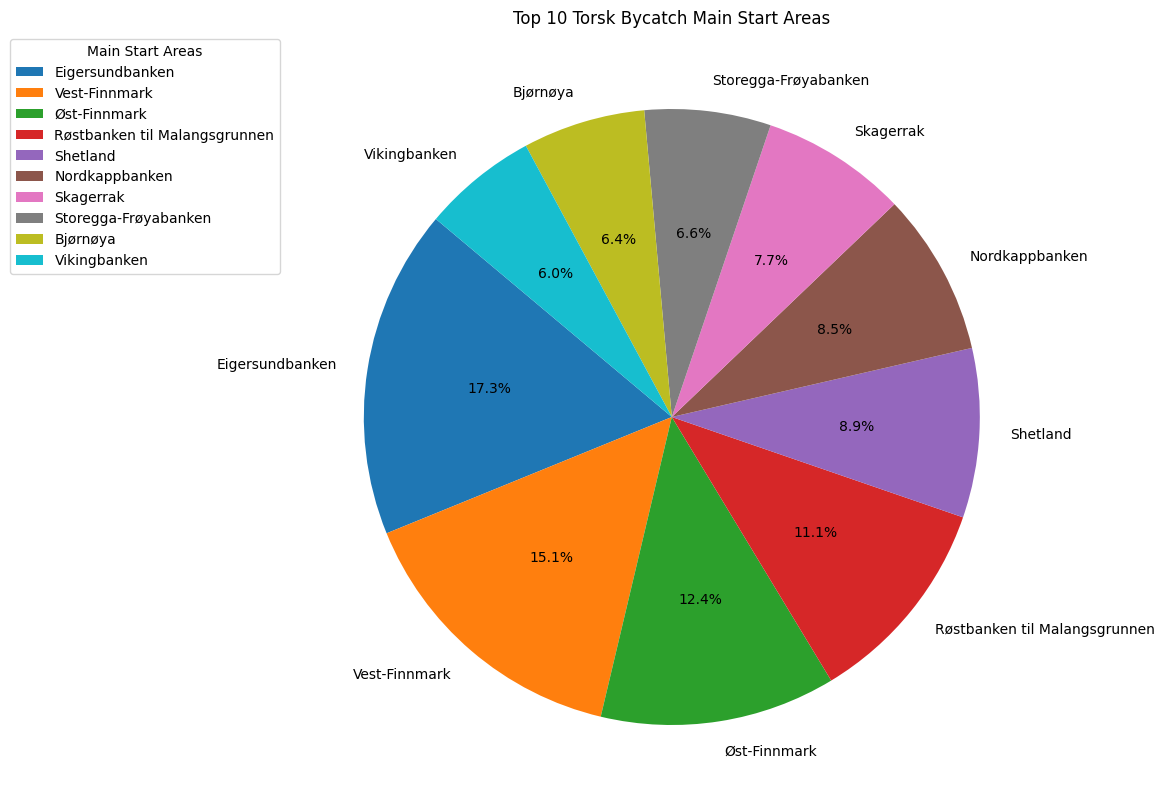

In [8]:

# Count the occurrences of each unique value in "Hovedområde start", sort, and select top 10
top_10_areas_bycatch_start = torsk_only_Bycatch["Hovedområde start"].value_counts().head(10)

# Plot the top 10 areas
top_10_areas_bycatch_start.plot(kind="pie", figsize=(12, 10), fontsize=10, autopct="%1.1f%%", startangle=140)

plt.title("Top 10 Torsk Bycatch Main Start Areas", fontsize=12)
plt.ylabel("")
plt.legend(title="Main Start Areas", loc="upper right", bbox_to_anchor=(0, 1))
plt.show()


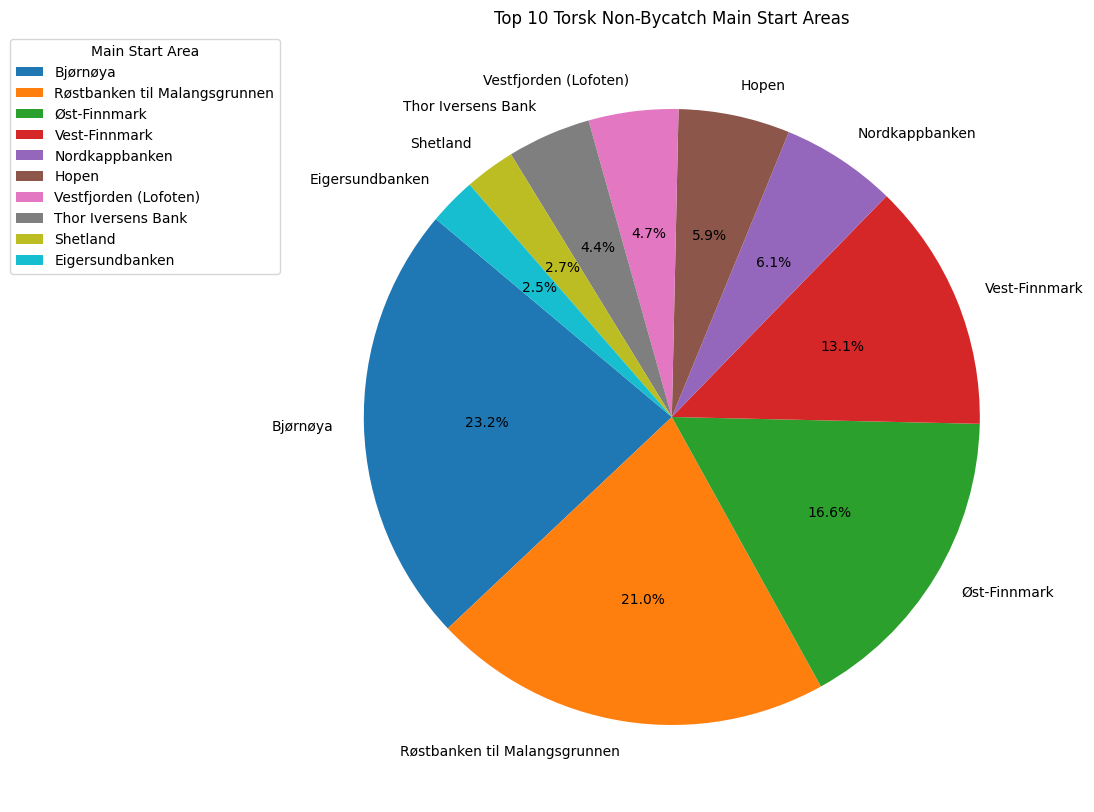

In [9]:

# Count the occurrences of each unique value in "Hovedområde start", sort, and select top 10
top_10_areas = torsk_only_main["Hovedområde start"].value_counts().head(10)

# Plot the top 10 areas
top_10_areas.plot(kind="pie", figsize=(12, 10), fontsize=10, autopct="%1.1f%%", startangle=140)

plt.title("Top 10 Torsk Non-Bycatch Main Start Areas", fontsize=12)
plt.ylabel("")
plt.legend(title="Main Start Area", loc="upper right", bbox_to_anchor=(0, 1))
plt.show()

We noticed that the distribution of areas between the two datasets differed. 

In [19]:
# Excluding all features that aren't relevant
dataset = dataset[["Hovedart FAO", "Art FAO", "Lengdegruppe", "Redskap FAO", "Rundvekt", "Hovedområde start"]]

We dropped all features except: “Art FAO” , “Hovedart FAO”, “Redskap FAO”, “Rundvekt”, “Lengdegruppe” , “Hovedområde start”. 

In hindsight, we could have benefited from automatic feature selection methods, such as univariate statistics (Müller & Guido, 2016, p. 236); however, we were not aware of this method at the time.

### Analyzation
In this section, we identified outliers and missing values in our dataset. We evaluated their significance, and decided whether to keep, modify, or remove them.

According to Müller and Guido (2016), outliers are odd data points that can lead to trouble for other scaling techniques. (p.133)

#### Hovedart FAO
These were our key features therefore; we didn’t remove or identify any outliers. We dropped all missing values in these features since without these features it is impossible to classify them as Bycatch.

In [20]:
# Counting all Na values
print(dataset["Hovedart FAO"].isna().sum())
print(dataset["Art FAO"].isna().sum())

# Drop all rows where Hovedart FAO and Art FAO is NaN
dataset = dataset.dropna(subset=["Hovedart FAO", "Art FAO"])

print(dataset["Hovedart FAO"].isna().sum())
print(dataset["Art FAO"].isna().sum())

4978
4982
0
0


#### Lengdegruppe
There were only 3 categories in this feature, the only thing to look out for were missing values.

In [21]:
# Counting all Na values
print(dataset["Lengdegruppe"].isna().sum())

lengdegruppe_is_NaN = dataset[(dataset["Lengdegruppe"].isna())]

# Checking samples where lengdegruppe is Na
pd.DataFrame(lengdegruppe_is_NaN.head(10))

683


,Hovedart FAO,Art FAO,Lengdegruppe,Redskap FAO,Rundvekt,Hovedområde start
347,Stortare,Stortare,NaN,"Skrape, mekanisert",125000.000000,Storegga-Frøyabanken
939,Stortare,Stortare,NaN,"Skrape, mekanisert",128000.000000,NaN
1486,Stortare,Stortare,NaN,"Skrape, mekanisert",93000.000000,Helgelandsbanken
1512,Stortare,Stortare,NaN,"Skrape, mekanisert",118000.000000,Storegga-Frøyabanken
1608,Stortare,Stortare,NaN,"Skrape, mekanisert",80000.000000,Helgelandsbanken
2260,Stortare,Stortare,NaN,"Skrape, mekanisert",82000.000000,Helgelandsbanken
2363,Stortare,Stortare,NaN,"Skrape, mekanisert",90000.000000,Helgelandsbanken
2785,Stortare,Stortare,NaN,"Skrape, mekanisert",55000.000000,Helgelandsbanken
5791,Stortare,Stortare,NaN,"Skrape, mekanisert",74000.000000,Helgelandsbanken
5792,Stortare,Stortare,NaN,"Skrape, mekanisert",75000.000000,Storegga-Frøyabanken


There were only 683 missing values, we inspected them further to find any patterns. 

In [22]:
# Printing the counts
print(lengdegruppe_is_NaN["Art FAO"].value_counts())

Art FAO
Stortare    683
Name: count, dtype: int64


All the missing values were from catching kelp, we chose to convert them into its own category. 

In [23]:
# Make new category in lengdegruppe
dataset["Lengdegruppe"] = dataset["Lengdegruppe"].fillna("Stortare båter")

#### Redskap FAO

In [24]:
# Counting all Na values
print(dataset["Redskap FAO"].isna().sum())
redskap_FAO_is_NaN = dataset[dataset["Redskap FAO"].isna()]
pd.DataFrame(redskap_FAO_is_NaN).head(10)


187


,Hovedart FAO,Art FAO,Lengdegruppe,Redskap FAO,Rundvekt,Hovedområde start
13304,Torsk,Torsk,"21-27,99 m",NaN,1650.000000,Vest-Finnmark
13305,Torsk,Sei,"21-27,99 m",NaN,420.000000,Vest-Finnmark
13306,Torsk,Hyse,"21-27,99 m",NaN,5.000000,Vest-Finnmark
13307,Torsk,Torsk,"21-27,99 m",NaN,6300.000000,Vest-Finnmark
13308,Torsk,Sei,"21-27,99 m",NaN,50.000000,Vest-Finnmark
13309,Torsk,Torsk,"21-27,99 m",NaN,6800.000000,Vest-Finnmark
13310,Torsk,Hyse,"21-27,99 m",NaN,10.000000,Vest-Finnmark
13311,Torsk,Sei,"21-27,99 m",NaN,10.000000,Vest-Finnmark
13312,Torsk,Torsk,"21-27,99 m",NaN,1825.000000,Vest-Finnmark
13313,Torsk,Sei,"21-27,99 m",NaN,100.000000,Vest-Finnmark


In [25]:
# Drop Na values
dataset = dataset.dropna(subset=["Redskap FAO"])

#### Rundvekt

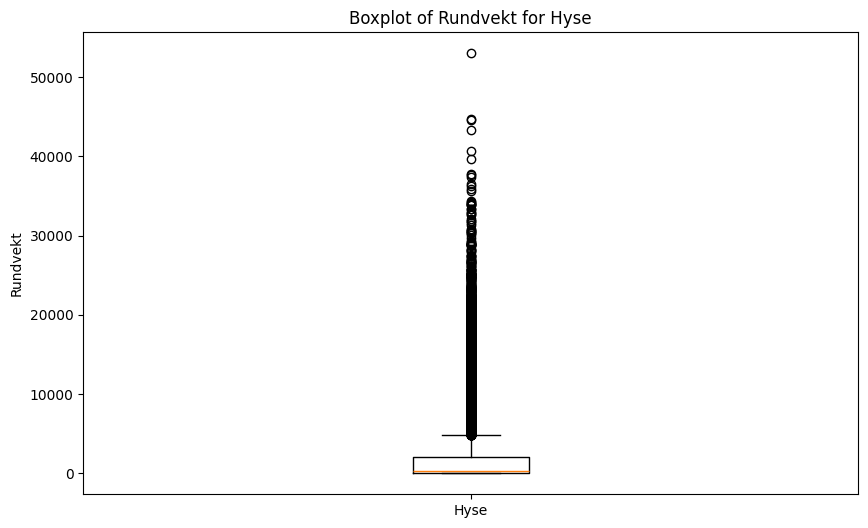

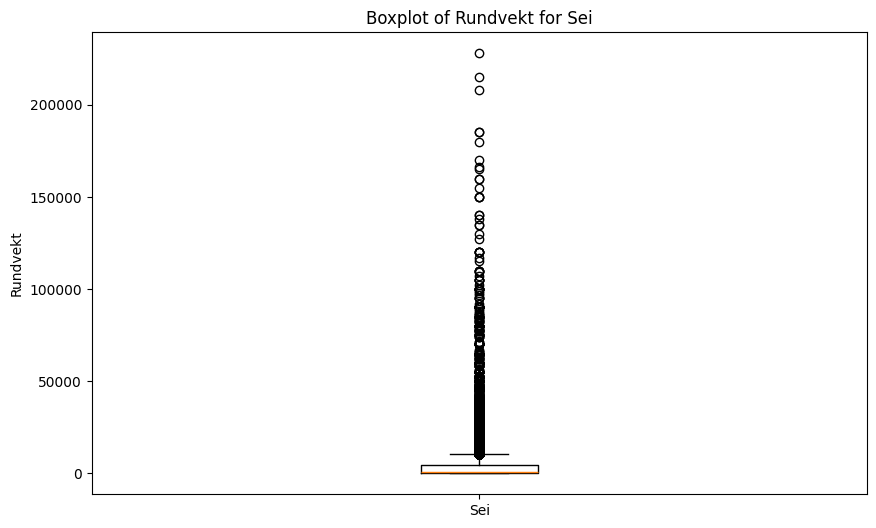

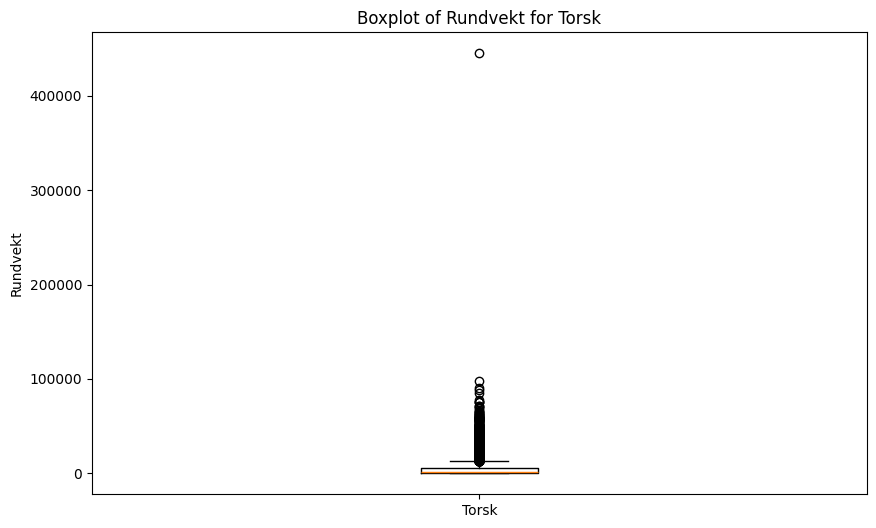

In [26]:
# Add all values in a list
species_grossweight = dataset.groupby("Art FAO")["Rundvekt"].apply(list)

# The three most popular fishes
species_of_interest = ["Torsk", "Hyse", "Sei"]

# Filter the data to include only the species we want
filtered_species_grossweight = {species: weights for species, weights in species_grossweight.items() if species in species_of_interest}

# Make box plots of gross weight
for species, grossweights in filtered_species_grossweight.items():
    plt.figure(figsize=(10, 6)) 
    plt.boxplot(grossweights)
    plt.title(f"Boxplot of Rundvekt for {species}")
    plt.ylabel("Rundvekt")
    plt.xticks([1], [species]) 
    
    plt.show()

According to Müller and Guido (2016), a practical approach is employing a RobustScaler. This method effectively transforms the data by minimizing the influence of extreme deviations, which is ideal for our dataset where outliers are common but cannot be simply removed. (p.133)

In [27]:
# Checking for Na values
print(dataset["Rundvekt"].isna().sum())

0


#### Startområde

In [28]:
# Checking for Na values
print(dataset["Hovedområde start"].isna().sum())

3788


In [29]:
# Dropping Na values
dataset = dataset.dropna(subset=["Hovedområde start"])

## Supervised learning

### Picking the Machine learning models 
Considering our dataset has 5 features (4 categorical, 1 continuous) and we are working with a binary classification problem. We need to choose models that can effectively handle this data.

### Our choices 
- Logistic Regression: Logistic regression, described as the following according to Müller and Guido (2016), "Go-to as a first algorithm to try, good for very large datasets, good for very high-dimensional data" (p. 128), was found to be the best fit for our problem since it is one of the two most common linear classification algorithms (p. 56), and we have previous experience with it. This model will function as our baseline model due to its simplistic nature. 
  
- Gradient Boosting Forest: Gradient Boosting Forest, described as the following according to Müller and Guido (2016), "Often slightly more accurate than random forests. Slower to train but faster to predict than random forests, and smaller in memory. Need more parameter tuning than random forests" (p. 128), was chosen because it takes less memory than a random forest, which allows us to run it on most hardware

- Neural Network: "Neural networks have a considerable succsess in low-level reasoning for with there is aboundant training data ... one reason is that they are very flexible and can invent features ... As far as learning is conserned, neural network provide a different measure of simplicity as a learning bias then, for eksample, decision trees. Multilayer neural networks, like decision tree, can represent any function of a set of discreat features." [Alan K.Mackworth, David L. Poole (2017). p.309. "Artificial intelligence, Foundations of computational agents". Cambridge, United Kingdom: Cambridge University Press]

### Transforming dataset

#### Target variable

In [30]:
# Create a new binary feature to use as target variable. 
dataset["Is_Bycatch"] = (dataset["Hovedart FAO"] != dataset["Art FAO"])

#### Changing categorical data into numeric data
Our dataset includes 5 categorical features with numerous categories each, making One-hot Encoding impractical due to the high dimensionality it would introduce. We used cat.codes to convert these categories into numeric values, see the guide provided by Saturn Cloud on this topic (Saturn Cloud, 2024) 

In [31]:
# Changing categorical data into numeric data using "cat.codes"
dataset["Art FAO"] = dataset["Art FAO"].astype("category")
dataset["Art FAO Codes"] = dataset["Art FAO"].cat.codes

dataset["Lengdegruppe"] = dataset["Lengdegruppe"].astype("category")
dataset["Lengdegruppe Codes"] = dataset["Lengdegruppe"].cat.codes

dataset["Hovedområde start"] = dataset["Hovedområde start"].astype("category")
dataset["Hovedområde start Codes"] = dataset["Hovedområde start"].cat.codes 

dataset["Redskap FAO"] = dataset["Redskap FAO"].astype("category")
dataset["Redskap FAO Codes"] = dataset["Redskap FAO"].cat.codes 

# Excluding the old features
dataset = dataset[["Art FAO Codes", "Lengdegruppe Codes", "Redskap FAO Codes", "Rundvekt", "Hovedområde start Codes", "Is_Bycatch"]]

#### Train Test Split

In [32]:
from sklearn.model_selection import train_test_split

# Splitting dataset 
X = dataset[["Art FAO Codes", "Lengdegruppe Codes", "Redskap FAO Codes", "Rundvekt", "Hovedområde start Codes"]]
y = dataset["Is_Bycatch"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

#### Scaling "Rundvekt"

In [33]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# Scaling only "Rundvekt" and not the others
ct = ColumnTransformer(
    [("scale", RobustScaler(), ["Rundvekt"])],
    remainder="passthrough"
)

# Fitting the scaler to the training set and not the test set to prevent data leakage
X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

### Implementation and evaluation
We evaluated our model using cross-validation paired with a grid search to optimize performance:

Cross-Validation: "Cross-validation is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set" (Müller & Guido, 2016, p. 252). We opted for the stratified k-Fold Cross-Validation, which was suitable for our dataset due to the significant disparities in sample sizes across different fish species. This method ensures each fold copies the overall dataset composition, thereby enhancing the reliability of our model evaluation.

Grid Search: This technique was employed to tune the model’s parameters, aiming to improve its generalization across new data sets.

Success Metric: The model's effectiveness was gauged by its ability to minimize false negatives, reducing potential misreporting within our data. This will be checked by utilizing a confusion matrix.

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import precision_recall_curve
from mglearn.datasets import make_blobs
from sklearn.pipeline import Pipeline

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Running a basic implementation of the model
logreg = LogisticRegression(random_state=10)

logreg.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.5f}".format(logreg.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.5f}".format(logreg.score(X_test_scaled, y_test)))

# Printing a confusion matrix to check false positives and negatives
cm = confusion_matrix(y_test, logreg.predict(X_test_scaled))
print("Confusion Matrix:")
print(cm)

The model’s accuracy on the training and test set were similar. The similarity in accuracy likely stems from the model's simplicity, which may not capture the underlying patterns, or from the data being too sparse for certain species.

Reviewing the confusion matrix, the false negative rate is low when compared to the false positives.  

To get a proper understanding of the accuracy of this model we will be running a stratified k-Fold before tuning the hyperparameter, since the dataset is large, we will be using 10 folds.

In [ ]:
# Running cross validation
logreg = LogisticRegression(random_state=10)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# List to hold accuracies for train and test set
accuracy_cross_validation_test= []
accuracy_cross_validation_train = []
cnf_matrix = []

# for each train and test fold, scale it, fit it to the model append the accuracy score in their respective lists
for train_index, test_index in skf.split(X, y):

    # Makes a train_test split from the fold using indexing
    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    # Scale the X dataset
    X_train_fold_scaled = ct.fit_transform(X_train_fold)
    X_test_fold_scaled = ct.transform(X_test_fold)

    logreg.fit(X_train_fold_scaled, y_train_fold)

    accuracy_cross_validation_train.append(logreg.score(X_train_fold_scaled, y_train_fold))
    accuracy_cross_validation_test.append(logreg.score(X_test_fold_scaled, y_test_fold))
    cnf_matrix.append(confusion_matrix(y_test_fold, logreg.predict(X_test_fold_scaled)))

highest_diff = (0,0)
most_accurate_score = (0,0)
least_accurate_score = (0,1)

# Print out the accuracies
for i in enumerate(accuracy_cross_validation_test):
    train = accuracy_cross_validation_train[i[0]]
    test = accuracy_cross_validation_test[i[0]]
    diff = train-test

    # Finding interesting details
    if abs(diff) > abs(highest_diff[1]):
        highest_diff = (i[0], diff)
    
    if test > most_accurate_score[1]:
        most_accurate_score = (i[0], test)
    
    if test < least_accurate_score[1]:
        least_accurate_score = (i[0], test)

    print(f"Fold {i[0]+1}")
    print(f"Confusion Matrix:\n{cnf_matrix[i[0]]}")
    print(f"Accuracy score for the training set: {train:.3f}")
    print(f"Accuracy score for the test set: {test:.3f}") 
    print(f"Difference in test and train set: {diff}")
    print("\n")

print(f"The highest accuracy the model achieved was {most_accurate_score[1]}, this was in fold {most_accurate_score[0]+ 1 }")
print(f"The lowest accuracy the model achieved was {least_accurate_score[1]}, this was in fold {least_accurate_score[0]+ 1 }")
print(f"The highest difference the model got was {highest_diff[1]}, this was in fold {highest_diff[0] + 1}")

The model performs well, with a maximum train/test score difference of -0.004 and a minimum accuracy of 83.91%, indicating stability and consistency without overfitting. According to Müller and Guido (2016), "Overfitting occurs when you fit a model too closely to the particularities of the training set and obtain a model that works well on the training set but is not able to generalize to new data" (p. 28). The top accuracy suggests potential underfitting or issues with dataset imbalance according to Müller and Guido (2016), "Choosing too simple a model is called underfitting" (p. 28). This is likely due to large variances in sample sizes across species, making it easier to predict common species like 'torsk' compared to rarer ones like "steinbiter" or "lanternfish". 

Using a grid search, we can optimize our model's parameters to enhance its complexity and improve generalization. This should help in reducing false predictions in our dataset. Müller and Guido (2016) describes generalization as a model that is able to make accurate predictions on unseen data (p. 26). Parameters are changes you can make to the model to change how well it generalizes to the train data. We will use the F1 score to evaluate performance, according to Müller and Guido (2016), the F1 score takes precision and recall into account and can be a better measure on imbalanced binary classification datasets (p. 284).

The parameters adjusted will be:

C (Regularization Strength): Increasing C should help the model capture more data nuances due to a lower bias and higher variance.

Penalty (Regularization Norm): We will try the L2 norm and none. Because we consider all features important, we will not be trying L1 norm.

Solver: We will test “sag” and “newton-cholesky” against the default “lbfgs”. “Sag” is recommended for large datasets, and “newton-cholesky” is ideal for our case where the number of samples exceeds the number of features.

max_iter (Maximum Iterations): This will control the convergence of the solvers. Convergence refers to the process where the algorithm reaches a stable solution."

We built a pipeline for the grid search to prevent data leakage from the test split into the parameters. According to Müller and Guido (2016), pipelines prevents data leakage by refitting the robust scaler using only the training data for each cross-validation fold (p. 307).


In [ ]:
# Building a pipeline
pipe = Pipeline([("scaler", ct), ("logreg", LogisticRegression(random_state=10))])

# Defining our parameter grid
param_grid = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10,100],
    "logreg__penalty": ["None","l2"],
    "logreg__solver": ["lbfgs", "sag", "newton-cg"],
    "logreg__max_iter": [10, 100, 1000, 10000]}

# Using the same amount of k-Folds as the amount we used in cross validation
# Using an f1 scorer to score based on precision and not on accuracy
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, verbose=1, scoring=make_scorer(f1_score))

# Using the train test split from section [33]
grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

According to the gridsearch, the best parameters possible for our model is {'logreg__C': 100, 'logreg__max_iter': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'sag'}. 

This combination achieved a very high accuracy. The “sag” solver was most efficient, likely due to large fold sizes (10,000+ samples). As anticipated, “L2” regularization was most effective given our handpicked features.

Surprisingly, a high C parameter value was better for the model, suggesting that less regularization (higher C implies weaker regularization) was beneficial. This indicates that our chosen features were distinct enough which made it easier to generalize.


In [ ]:
# Running cross validation with best parameters
logreg = LogisticRegression(C=100, max_iter=10, penalty="l2", solver="sag", random_state=10)
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# List to hold accuracies for train and test set
accuracy_cross_validation_test= []
accuracy_cross_validation_train = []
cnf_matrix = []

# for each train and test fold, scale it, fit it to the model append the accuracy score in their respective lists
for train_index, test_index in skf.split(X, y):

    # Makes a train_test split from the fold using indexing
    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    # Scale the X dataset
    X_train_fold_scaled = ct.fit_transform(X_train_fold)
    X_test_fold_scaled = ct.transform(X_test_fold)

    logreg.fit(X_train_fold_scaled, y_train_fold)

    accuracy_cross_validation_train.append(logreg.score(X_train_fold_scaled, y_train_fold))
    accuracy_cross_validation_test.append(logreg.score(X_test_fold_scaled, y_test_fold))
    cnf_matrix.append(confusion_matrix(y_test_fold, logreg.predict(X_test_fold_scaled)))

highest_diff = (0,0)
most_accurate_score = (0,0)
least_accurate_score = (0,1)

# Print out the accuracies
for i in enumerate(accuracy_cross_validation_test):
    train = accuracy_cross_validation_train[i[0]]
    test = accuracy_cross_validation_test[i[0]]
    diff = train-test

    # Finding interesting details
    if abs(diff) > abs(highest_diff[1]):
        highest_diff = (i[0], diff)
    
    if test > most_accurate_score[1]:
        most_accurate_score = (i[0], test)
    
    if test < least_accurate_score[1]:
        least_accurate_score = (i[0], test)

    print(f"Fold {i[0]+1}")
    print(f"Confusion Matrix:\n{cnf_matrix[i[0]]}")
    print(f"Accuracy score for the training set: {train:.3f}")
    print(f"Accuracy score for the test set: {test:.3f}") 
    print(f"Difference in test and train set: {diff}")
    print("\n")

print(f"The highest accuracy the model achieved was {most_accurate_score[1]}, this was in fold {most_accurate_score[0]+ 1 }")
print(f"The lowest accuracy the model achieved was {least_accurate_score[1]}, this was in fold {least_accurate_score[0]+ 1 }")
print(f"The highest difference the model got was {highest_diff[1]}, this was in fold {highest_diff[0] + 1}")

Adjusting parameters slightly increased model stability and accuracy, our model achieved a slightly higher peak accuracy

Results for Fold 6 showed a decrease in the false positive rate to 12.62% from 12.79% and an increase in the false negative rate to 2.76% from 2.60%, compared to the unoptimized model. This shift likely stems from the f1 scorer's emphasis on the harmonic mean of precision and recall, as discussed in "Introduction to Machine Learning" (p.283). 

To further reduce false negatives, we considered trading precision for recall. According to Müller and Guido (2016), a precision-recall curve can be used to see all possible trade-offs of precision and recall (p. 289). "Precision measures how many of the samples predicted as positive are actually positive" (p. 282). "Recall is used as a performance metric when we need to identify all positive samples; that is, when it is important to avoid false negatives" (p. 283).

Text(0, 0.5, 'Recall')

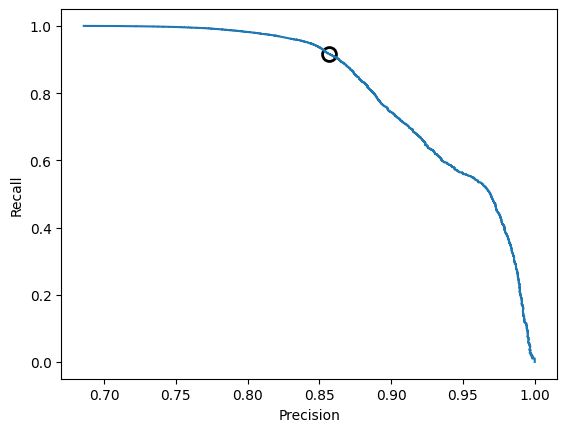

In [51]:

logreg = LogisticRegression(C=100, max_iter=10, penalty="l2", solver="sag", random_state=10).fit(X_train_scaled, y_train)
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test, logreg.decision_function(X_test_scaled))

# find threshold closest to 0.5
close_default_logreg = np.argmin(np.abs(thresholds_logreg-0.5))
plt.plot(precision_logreg[close_default_logreg], recall_logreg[close_default_logreg], "o", markersize=10,
label="threshold 0.5", fillstyle="none", c="k", mew=2)
plt.plot(precision_logreg, recall_logreg, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

### Gradient boosted regression trees

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Running a basic implementation
gbrt = GradientBoostingClassifier(random_state=10)

gbrt.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test_scaled, y_test)))

# Printing a confusion matrix to check false positives and negatives
cm = confusion_matrix(y_test, gbrt.predict(X_test_scaled))
print("Confusion Matrix:")
print(cm)

The model got high accuracy on both the training and test sets, showing no signs of overfitting. The confusion matrix shows similar amount of false negatives and false positives. These low rates indicates a promising model.

In [ ]:
# Running a cross validation.
gbrt = GradientBoostingClassifier(random_state=10)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# List to hold accuracies for train and test set
accuracy_cross_validation_test= []
accuracy_cross_validation_train = []
cnf_matrix = []

# for each train and test fold, scale it, fit it to the model append the accuracy score in their respective lists
for train_index, test_index in skf.split(X, y):

    # Makes a train_test split from the fold using indexing
    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    # Scale the X dataset
    X_train_fold_scaled = ct.fit_transform(X_train_fold)
    X_test_fold_scaled = ct.transform(X_test_fold)

    gbrt.fit(X_train_fold_scaled, y_train_fold)

    accuracy_cross_validation_train.append(gbrt.score(X_train_fold_scaled, y_train_fold))
    accuracy_cross_validation_test.append(gbrt.score(X_test_fold_scaled, y_test_fold))
    cnf_matrix.append(confusion_matrix(y_test_fold, gbrt.predict(X_test_fold_scaled)))

highest_diff = (0,0)
most_accurate_score = (0,0)
least_accurate_score = (0,1)

# Print out the accuracies
for i in enumerate(accuracy_cross_validation_test):
    train = accuracy_cross_validation_train[i[0]]
    test = accuracy_cross_validation_test[i[0]]
    diff = train-test

    # Finding interesting details
    if abs(diff) > abs(highest_diff[1]):
        highest_diff = (i[0], diff)
    
    if test > most_accurate_score[1]:
        most_accurate_score = (i[0], test)
    
    if test < least_accurate_score[1]:
        least_accurate_score = (i[0], test)

    print(f"Fold {i[0]+1}")
    print(f"Confusion Matrix:\n{cnf_matrix[i[0]]}")
    print(f"Accuracy score for the training set: {train:.3f}")
    print(f"Accuracy score for the test set: {test:.3f}") 
    print(f"Difference in test and train set: {diff}")
    print("\n")

print(f"The highest accuracy the model achieved was {most_accurate_score[1]}, this was in fold {most_accurate_score[0]+ 1 }")
print(f"The lowest accuracy the model achieved was {least_accurate_score[1]}, this was in fold {least_accurate_score[0]+ 1 }")
print(f"The highest difference the model got was {highest_diff[1]}, this was in fold {highest_diff[0] + 1}")

The model performs consistently well, it shows stable results across all folds. This model is achieving a 5% higher accuracy than our baseline model, which is very good considering it hasn't been tuned. There also seems so be no clear sign of underfitting or overfitting with the highest difference between test/train set being a 0.3%. The model may be performing better than our baseline model due to the complex relationships in our data. 

We ran a grid search to try to optimize the model. 

The parameters adjusted will be:
- max_depth: This parameter adjusts the depth limit in the tree, controlling the complexity of the decision tree model (scikit-learn, n.d.).

- n_estimators: According to Müller and Guido (2016), this parameter represents the number of trees in the model. Increasing the number of estimators can enhance model complexity and performance.

- learning_rate: Müller and Guido (2016) explains that the learning rate determines the contribution of each tree in the ensemble. A higher learning rate allows each tree to make stronger corrections to the model (p. 89).

In [ ]:
pipe = Pipeline([("scaler", ct), ("gbrt", GradientBoostingClassifier(random_state=10))])

# Defining our parameter grid
param_grid = {
    "gbrt__max_depth": [2, 3, 5],  # Not deeper than five according to Müller and Guido (2016), ( p.92)
    "gbrt__n_estimators": [25, 50, 100, 200, 300, 400],  
    "gbrt__learning_rate": [0.01, 0.1, 0.2, 0.5,1]  
}


# Using the same amount of k-Folds as the amount we used in cross validation
# Using an f1 scorer to score based on precision and not on accuracy
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, verbose=1, scoring=make_scorer(f1_score))

# Using the train test split from section [33]
grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

We achieved a high F1 score using these parameters, suggesting that our model performs best with a high number of trees. The maximum depth of 5 and maximum n_estimators is likely due to how many categories there are in each feature. 

In [ ]:
gbrt = GradientBoostingClassifier(learning_rate=0.2, max_depth=5 ,n_estimators=400, random_state=10)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# List to hold accuracies for train and test set
accuracy_cross_validation_test= []
accuracy_cross_validation_train = []
cnf_matrix = []

# for each train and test fold, scale it, fit it to the model append the accuracy score in their respective lists
for train_index, test_index in skf.split(X, y):

    # Makes a train_test split from the fold using indexing
    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    # Scale the X dataset
    X_train_fold_scaled = ct.fit_transform(X_train_fold)
    X_test_fold_scaled = ct.transform(X_test_fold)

    gbrt.fit(X_train_fold_scaled, y_train_fold)

    accuracy_cross_validation_train.append(gbrt.score(X_train_fold_scaled, y_train_fold))
    accuracy_cross_validation_test.append(gbrt.score(X_test_fold_scaled, y_test_fold))
    cnf_matrix.append(confusion_matrix(y_test_fold, gbrt.predict(X_test_fold_scaled)))

highest_diff = (0,0)
most_accurate_score = (0,0)
least_accurate_score = (0,1)

# Print out the accuracies
for i in enumerate(accuracy_cross_validation_test):
    train = accuracy_cross_validation_train[i[0]]
    test = accuracy_cross_validation_test[i[0]]
    diff = train-test

    # Finding interesting details
    if abs(diff) > abs(highest_diff[1]):
        highest_diff = (i[0], diff)
    
    if test > most_accurate_score[1]:
        most_accurate_score = (i[0], test)
    
    if test < least_accurate_score[1]:
        least_accurate_score = (i[0], test)

    print(f"Fold {i[0]+1}")
    print(f"Confusion Matrix:\n{cnf_matrix[i[0]]}")
    print(f"Accuracy score for the training set: {train:.3f}")
    print(f"Accuracy score for the test set: {test:.3f}") 
    print(f"Difference in test and train set: {diff}")
    print("\n")

print(f"The highest accuracy the model achieved was {most_accurate_score[1]}, this was in fold {most_accurate_score[0]+ 1 }")
print(f"The lowest accuracy the model achieved was {least_accurate_score[1]}, this was in fold {least_accurate_score[0]+ 1 }")
print(f"The highest difference the model got was {highest_diff[1]}, this was in fold {highest_diff[0] + 1}")

We achieved a 2% increase in accuracy with the optimized model . This model also achieved a significantly higher recall rate, which is likely due to our choice of the F1 score as the success metric. Precision was generally improved as well.

However, there were indications of potential overfitting, as observed in the results from fold 7. This trend was noticeable across all folds, though the differences were not substantial enough to conclusively determine if overfitting is occurring.

This model was a big improvement over our baseline model, it achieved a significantly lower false positive rate and a much higher precision.

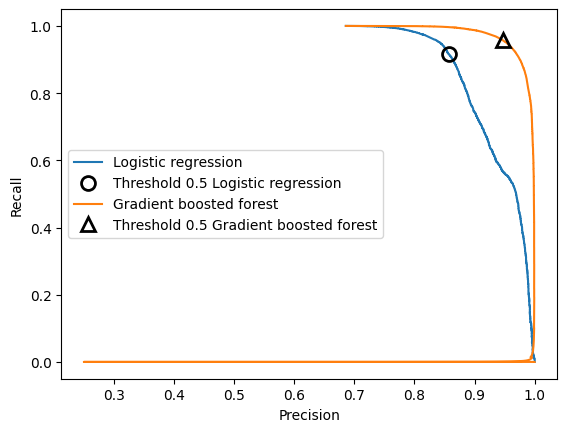

: 

In [53]:
gbrt = GradientBoostingClassifier(learning_rate=0.2, max_depth=5 ,n_estimators=400, random_state=10).fit(X_train_scaled, y_train)

precision_gbrt, recall_gbrt, thresholds_gbrt = precision_recall_curve(y_test, gbrt.predict_proba(X_test_scaled)[:, 1])
plt.plot(precision_logreg, recall_logreg, label="Logistic regression")
plt.plot(precision_logreg[close_default_logreg], recall_logreg[close_default_logreg], 'o', markersize=10,label="Threshold 0.5 Logistic regression", fillstyle="none", c='k', mew=2)

plt.plot(precision_gbrt, recall_gbrt, label="Gradient boosted forest")
close_default_gbrt = np.argmin(np.abs(thresholds_gbrt - 0.5))
plt.plot(precision_gbrt[close_default_gbrt], recall_gbrt[close_default_gbrt], '^', c='k',markersize=10, label="Threshold 0.5 Gradient boosted forest", fillstyle="none", mew=2)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

The Gradient Boosted Forest consistently outperforms Logistic Regression across all threshold levels on the precision-recall curve, it maintains high precision even as recall increases. This shows that it is better at classifying positive instances without getting many false positives, making it the better model of the two. 

### Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

A basic implementation of a neural network and something to compare the testing and fine tuning to come.

In [ ]:
mlp = MLPClassifier(verbose=False, hidden_layer_sizes=(10, 5), learning_rate_init=0.001, random_state=50)

mlp.fit(X_train_scaled, y_train)

y_test_pred = mlp.predict(X_train_scaled)
train_accuracy = accuracy_score(y_test_pred, y_train)
print("Training accuracy: ", train_accuracy)


y_pred = mlp.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(f"Confusion Matrix: {confusion_matrix(y_test, y_pred)}")

In [ ]:
skf = StratifiedKFold(n_splits=10)

training_acc_list = []
testing_acc_list =[]
con_x_list = []
o_u_fitting_list= []


for train_index, test_index in skf.split(X, y):

    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    X_train_fold_scaled = ct.fit_transform(X_train_fold)
    X_test_fold_scaled = ct.transform(X_test_fold)

    mlp.fit(X_train_fold_scaled, y_train_fold)

    training_acc_list.append(mlp.score(X_train_fold_scaled, y_train_fold))
    testing_acc_list.append(mlp.score(X_test_fold_scaled, y_test_fold))
    con_x_list.append(confusion_matrix(y_test_fold, mlp.predict(X_test_fold_scaled)))
    train_test_diff = (mlp.score(X_train_fold_scaled, y_train_fold)) - (mlp.score(X_test_fold_scaled, y_test_fold))
    o_u_fitting_list.append(train_test_diff)


print(training_acc_list, "\n", 
      testing_acc_list, "\n", 
      con_x_list, "\n", 
      o_u_fitting_list)

The output's second line reveals a significant 7% point gap between prediction rates (~85.6 to ~92.0), indicating sensitivity to data splitting. Without shuffling, it may indicate a concentration of certain data aspects, while with sufficient shuffling, it may reveal more entries with a specific label.

In 8/10 interactions, the confusion matrix shows a higher number of false positives than false negatives. But the values of the confusion matrix appear to be somewhat volatile and fluctuate within a range of a few hundred, so this is something to keep in mind for the future.

The final line shows differences in prediction accuracy between training and test data. Half the numbers are negative, suggesting the model performs worse on training data in this cross-validation iteration. Possible reasons for this could include data leakage, significant differences in the data splitting, or a model structure that isn't complex enough to fit the training data effectively.

To optimize the neural network parameters, and address potential issues mentioned earlier, a grid search was conducted having early-stopping enabled, F1 as the cross-validation scoring and utilizing pipeline.

In [ ]:
parameters = {"neural_net__activation": ["identity", "logistic", "tanh", "relu"],
              "neural_net__solver": ["lbfgs", "sgd", "adam"],
              "neural_net__learning_rate": ["constant", "invscaling", "adaptive"],
              "neural_net__learning_rate_init":[0.01, 0.001, 0.0001],
              "neural_net__hidden_layer_sizes": [(100,), (50,), (10,), (5,), (1,),  
                                                 (100, 50), (50, 50), (10, 5), (4, 2), (2, 2), ]      
} 

mlp = MLPClassifier(early_stopping=True, random_state=50)

pipe = Pipeline([("scaler", ct), ("neural_net", mlp)])

grid = GridSearchCV(pipe, 
                    param_grid=parameters, 
                    cv=10, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring=make_scorer(f1_score))

grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))
best_model = grid.best_estimator_

#[output] >>>

"""
Fitting 10 folds for each of 1512 candidates, totalling 15120 fits

Best cross-validation accuracy: 0.94
Test set score: 0.94
Best parameters: {'neural_net__activation': 'tanh', 
'neural_net__hidden_layer_sizes': (100, 50), 
'neural_net__learning_rate': 'constant', 
'neural_net__learning_rate_init': 0.001, 
'neural_net__solver': 'adam'}

"""

After grid searching parameters, the above settings yielded the optimal model performance. However, fine-tuning only resulted in a 2% point improvement over the best cross-validation score for the basic implementation. This improvement is relatively small, especially compared to the significant impact of data splitting on performance. It's possible that this minor enhancement is due to the model's high accuracy, with remaining mispredictions only slightly deviating from the overall pattern.

To achieve the final percentage points, further fine-tuning of the hidden layer is likely required. The output suggests that the most complex model performed the best, indicating that the current model might be too simplistic to effectively capture the underlying pattern. Further testing is necessary to comfirm this hypothesis.

In [ ]:
parameters = {"neural_net__activation": ["tanh"],
              "neural_net__solver": ["adam"],
              "neural_net__learning_rate": ["constant"],
              "neural_net__learning_rate_init":[0.001],
              "neural_net__hidden_layer_sizes": [(100, 50), (100, 100),
                                                 (10, 10, 10), (50, 50, 50), (100, 100, 100),
                                                 (50, 50, 50, 50)]      
} 

mlp = MLPClassifier(early_stopping=True, random_state=50)

pipe = Pipeline([("scaler", ct), ("neural_net", mlp)])

grid = GridSearchCV(pipe, 
                    param_grid=arameters, 
                    cv=10, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring=make_scorer(f1_score))

grid.fit(X_train, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))
best_model = grid.best_estimator_

The model's 1% point improvement confirms our theory. Despite an alternative parameter with more hidden layers but fewer neurons, it may not have been a more complex or suitable model. If we were to wish to improve the model any more in the future, a lot more exploring and fine tuning on this aspect of the model would be needed.

## Unsupervised learning

### Preprocessing for Unsupervised Learning

In [35]:
# Excluding Is_Bycatch
# Making a new dataset for unsupervised learning
# Excluding Is_Bycatch
dataset_unsuper = dataset[["Art FAO Codes", "Lengdegruppe Codes", "Redskap FAO Codes", "Rundvekt", "Hovedområde start Codes"]]

In [36]:
# Used same scaling method(RobustScaler) & transformation(label encoding transformation) with supervised learning

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# Scaling only "Rundvekt" and not the others
# since "Rundvekt" was separated into a training set and a test set in the previous transformation
ct = ColumnTransformer(
    [("scale", RobustScaler(), ["Rundvekt"])],
    remainder='passthrough'
)

# Fitting the scaler to the training set and not the test set to prevent data leakage
dataset_scaled = ct.fit_transform(dataset_unsuper)


#### Two Unsupervised Algorithms (from the textbook p.145)
1. Unsupervised Transformations: This algorithm creates a new data representation, often for dimensionality reduction or identifying data components. It's commonly used for visualization or feature extraction, but may not be ideal for deriving new information from our dataset, as we intended.
2. Clustering Algorithms: This method forms clusters within data, allowing the discovery of relationships beyond those observed during supervised learning.

#### Picking a Clustering Algorithm: Two Considerations to Pick DBSCAN as Our Algorithm (from the textbook p.168-188)

Firstly, our features are mostly categorical and have been transformed into numeric, making it impossible to calculate means for k-Means. Secondly, we are unsure of the number of clusters in the dataset, thus opting for DBSCAN instead of k-Means or agglomeration clustering.

### Clusturing with DBSCAN

#### Two Parameters
- `eps` defines the maximum distance between two samples to be considered as part of the same neighborhood.
- `min_samples` defines the number of samples in a neighborhood for a point to be considered as a core point.
[(scikit-learn developers. (2024), DBSCAN.)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#:~:text=DBSCAN%20%2D%20Density%2DBased%20Spatial%20Clustering,contains%20clusters%20of%20similar%20density)

#### About DBCSAN (from the textbook p.187-188)
DBSCAN selects a data point randomly, searches for nearby points within `eps` distance, and if there are more than `min_samples`, they form a cluster. Otherwise, the point is classified as noise.

In [37]:
from sklearn.cluster import DBSCAN

#eps = 0.5 (default)
for min in [10, 100, 200, 500, 1000, 10000]:
    print("\nmin_samples={}".format(min))
    dbscan = DBSCAN(min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    print("Cluster size:{}".format(np.bincount(clusters+1)))


min_samples=10
Clusters present: [  -1    0    1 ... 3762 3763 3764]
Cluster size:[221012    143     11 ...     10     18     11]

min_samples=100
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25]
Cluster size:[292868    143    104    103    134    199    113    164    106    172
    101    140    106    151    134    100    101    169    134    251
    260    145    102    112    124    134    107]

min_samples=200
Clusters present: [-1  0  1]
Cluster size:[295966    251    260]

min_samples=500
Clusters present: [-1]
Cluster size:[296477]

min_samples=1000
Clusters present: [-1]
Cluster size:[296477]

min_samples=10000
Clusters present: [-1]
Cluster size:[296477]


We generally run it and the result meets our expectation: the increase of min_samples, the decrease of number of clusters.

At min_samples = 500, all data points were considered noise, indicating it's likely the maximum suitable value for this project.

Moreover, majority of the data points is noise, especially noticeable when min_samples = 100. To lessen the size of noise, we thus attempted to deal with another parameter, eps.

In [38]:
# out of RAM --> cannot run
"""
for eps in [1, 10, 20, 50, 100]:
    print("\neps={}".format(eps))
    print("min_samples={}".format(10))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    print("Cluster size:{}".format(np.bincount(clusters+1)))
""" 


eps=1
min_samples=10
Clusters present: [  -1    0    1 ... 3935 3936 3937]
Cluster size:[180804    427    119 ...     10     11     14]

eps=10
min_samples=10
Clusters present: [  -1    0    1 ... 1347 1348 1349]
Cluster size:[ 46656 202521   1014 ...     10      7      7]

eps=20
min_samples=10
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 16

MemoryError: bad allocation

We looked at the change of the size of noise by increasing eps. However, we cannot run the whole for loop on our computers or on a google colab; it says that 'Your session crashed after using all available RAM' when eps = 20. Therefore, we tried different possible values below 20 for eps.

#### the Influence of the Values of Parameters

Observations revealed that the largest cluster dominates the dataset, prompting us to plot it for better understanding.

We also plotted graphs to compare noise size trends more effectively and will further investigate clustering changes based on eps.


> min_sampels = 10


eps=1
nmin_samples=10
Clusters present: [  -1    0    1 ... 3935 3936 3937]
Cluster size:[180804    427    119 ...     10     11     14]
Noise size: 180804
Largest cluster size: 1930

eps=3
nmin_samples=10
Clusters present: [  -1    0    1 ... 3294 3295 3296]
Cluster size:[133287    175   5690 ...     11     10     12]
Noise size: 133287
Largest cluster size: 7706

eps=5
nmin_samples=10
Clusters present: [  -1    0    1 ... 2146 2147 2148]
Cluster size:[ 98922 110265     34 ...     11     10     10]
Noise size: 98922
Largest cluster size: 110265

eps=7
nmin_samples=10
Clusters present: [  -1    0    1 ... 1806 1807 1808]
Cluster size:[ 73019 170450     36 ...     10      4      5]
Noise size: 73019
Largest cluster size: 170450

eps=9
nmin_samples=10
Clusters present: [  -1    0    1 ... 1613 1614 1615]
Cluster size:[ 54689 194479     62 ...     10      9      5]
Noise size: 54689
Largest cluster size: 194479

eps=11
nmin_samples=10
Clusters present: [  -1    0    1 ... 1131 1132 1133]

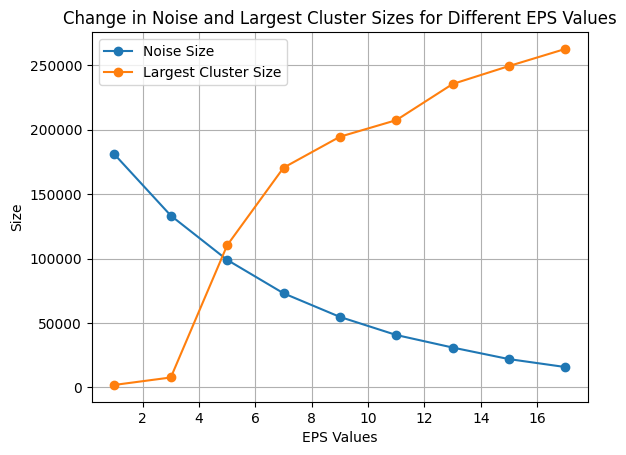

In [39]:
# min_samples = 10

eps_values = [1, 3, 5, 7, 9, 11, 13, 15, 17]
noise_sizes = []
largest_cluster_sizes = []

for eps in eps_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(10))
    dbscan = DBSCAN(eps=eps, min_samples=10)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(eps_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(eps_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different EPS Values')
plt.xlabel('EPS Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()

Increasing eps decreases noise size while increasing the largest cluster size. Notably, noise size significantly reduces from eps = 7, warranting focus on eps values starting from 7.

> min_examples = 100


eps=7
nmin_samples=100
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170]
Cluster size:[167829   1416  76455    190    291   1415    258    787    131    241
    200   4519    176    141    589    435    389    189   3701    182
    318    248    770    192    208    707    198    196    279    178
    260   1769    276    525    3

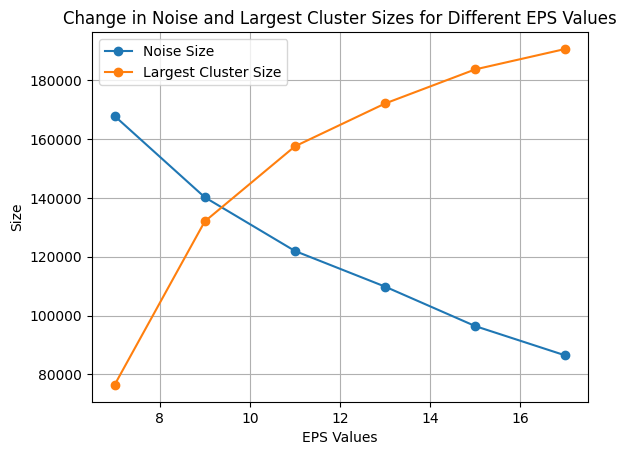

In [40]:
# min_exmaples = 100
min = 100
eps_values = [7, 9, 11, 13, 15, 17]
noise_sizes = []
largest_cluster_sizes = []

for eps in eps_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(min))
    dbscan = DBSCAN(eps=eps, min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(eps_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(eps_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different EPS Values')
plt.xlabel('EPS Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()

Similar trends are observed compared to the previous graph. Further investigation continues by increasing min_samples.

> min_examples = 200


eps=7
nmin_samples=200
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82]
Cluster size:[204895  30504  18596   1513    495    754    638   1226    426    745
    525   2001   4050    550    875    407    410    389   1842    361
    431    429    512    431    710    256    475    653    554    784
    504    309   1532    391    337    292    930    368    402    454
    422    450   1248    243    477    498    339    505    660    308
   1098    278    200    256    251    209    459    323    274    257
    260    191    250    703    311    256    225    200    283    232
    256    222    222    214    210    221    270    217     45    203
    208    237    127    203]
Noise size: 204895
Largest cluster size: 30504

eps=9
nmin_samples=200
Clusters present: [

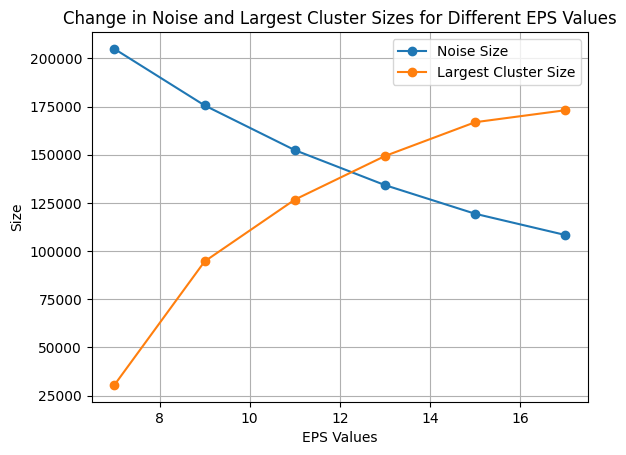

In [41]:
# min_samples = 200
min = 200
eps_values = [7, 9, 11, 13, 15, 17]
noise_sizes = []
largest_cluster_sizes = []

for eps in eps_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(min))
    dbscan = DBSCAN(eps=eps, min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(eps_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(eps_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different EPS Values')
plt.xlabel('EPS Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()

Noise size remains above 100,000, indicating over a third of the dataset is noise. To reduce noise, min_samples should stay below 100.


eps=17
nmin_samples=10
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 

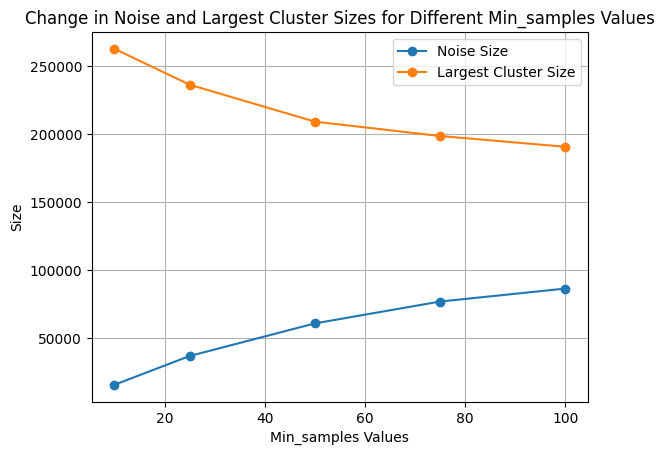

In [42]:
#eps = 17 and min_samples changes
min_values = [10, 25, 50, 75, 100]
eps = 17
noise_sizes = []
largest_cluster_sizes = []

for min in min_values:
    print("\neps={}".format(eps))
    print("nmin_samples={}".format(min))
    dbscan = DBSCAN(eps=eps, min_samples=min)
    clusters = dbscan.fit_predict(dataset_unsuper)
    print("Clusters present: {}".format(np.unique(clusters)))
    cluster_sizes = np.bincount(clusters + 1)
    noise_size = cluster_sizes[0]  # Size of noise is the count of points labeled as -1
    largest_cluster_size = np.max(cluster_sizes[1:]) if len(cluster_sizes) > 1 else 0
    print("Cluster size:{}".format(cluster_sizes))
    print("Noise size: {}".format(noise_size))
    print("Largest cluster size: {}".format(largest_cluster_size))
    noise_sizes.append(noise_size)
    largest_cluster_sizes.append(largest_cluster_size)

# Plotting
plt.plot(min_values, noise_sizes, marker='o', label='Noise Size')
plt.plot(min_values, largest_cluster_sizes, marker='o', label='Largest Cluster Size')
plt.title('Change in Noise and Largest Cluster Sizes for Different Min_samples Values')
plt.xlabel('Min_samples Values')
plt.ylabel('Size')
plt.legend()
plt.grid(True)
plt.show()

Unexpectedly, noise size slightly increases while the largest cluster steadily decreases, suggesting a different data distribution than expected. Due to limitations, we couldn't plot the dataset with PCA, hindering a deeper understanding of its distribution.

#### Is the Largest Cluster Related to Bycatch?

Manual evaluation, the only method for assessing unsupervised learning, seemed unfeasible due to numerous clusters. Since we utilizing features from supervised learning, we explored any correlation between clusters and bycatch.

During parameter exploration, we observed the dominant presence of the largest cluster, taking over 2/3 of the data points, and noted similarities with the bycatch count.

Subsequently, we investigated the relationship between the largest cluster and bycatch.

In [43]:
# The number of bycatch in the dataset

bycatch = np.sum(dataset["Is_Bycatch"] == 1)
no_bycatch = np.sum(dataset["Is_Bycatch"] == 0)

print("The number of bycatch:", bycatch)
print("The number of non-bycatch:", no_bycatch)

The number of bycatch: 203949
The number of non-bycatch: 92528


>Hypothesis: The largest cluster is bycatch and the other clusters or noise are non-bycatch.

In [44]:
# When the min_samples = 50 and eps = 17,
# the size of the largest cluster is similar to the number of bycatch and the size of noise is fewer

min = 50
eps = 17
print("\neps={}".format(eps))
print("min_samples={}".format(min))
dbscan = DBSCAN(eps=eps, min_samples=min)
clusters = dbscan.fit_predict(dataset_unsuper)
print("Clusters present: {}".format(np.unique(clusters)))
print("Cluster size:{}".format(np.bincount(clusters+1)))

# the largest cluster: cluster [0] with 209072 points
# noise: [-1] wih 60875 points


eps=17
min_samples=50
Clusters present: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140]
Cluster size:[ 60875 209072    518   1154    895    624    128   2436    261    537
    538    935    156    712    197    302    503    646    121    123
    549    197    298    107    142    771    236     79    136     64
    119    204    179     98    137    205    472     50    123    443
    121    360     99    123    201    147    225    258    146    168
    102    192

In [45]:
dataset["Cluster"] = clusters

In [46]:
# Creating an infusion matrix

import pandas as pd

dataset["correct_match"] = None
for index, row in dataset.iterrows():
    if row["Cluster"] == 0 and row["Is_Bycatch"] == 1:     # TT
        dataset.at[index, "correct_match"] = 1
    elif row["Cluster"] != 0 and row["Is_Bycatch"] == 0:   # FF
        dataset.at[index, "correct_match"] = 2
    elif  row["Cluster"] == 0 and row["Is_Bycatch"] == 0:  # TF
        dataset.at[index, "correct_match"] = 3
    elif  row["Cluster"] != 0 and row["Is_Bycatch"] == 1:  # FT
        dataset.at[index, "correct_match"] = 4

In [47]:
TT = np.sum(dataset["correct_match"] == 1)
FF = np.sum(dataset["correct_match"] == 2)
TF = np.sum(dataset["correct_match"] == 3)
FT = np.sum(dataset["correct_match"] == 4)

# Confusion matrix
print("Number of largest cluster and bycatch:", TT)
print("Number of largest cluster and non-bycatch:", TF)
print("Number of other clusters and bycatch:", FT)
print("Number of other clusters and non-bycatch:", FF)
print("Accuracy: {}".format((TT+FF)/(TT+TF+FT+FF)))

Number of largest cluster and bycatch: 182376
Number of largest cluster and non-bycatch: 26696
Number of other clusters and bycatch: 21573
Number of other clusters and non-bycatch: 65832
Accuracy: 0.837191417884018


The accuracy indicates that the largest cluster is likely bycatch, while other clusters (including noise) are interpreted as non-bycatch with 83.7% accuracy.

## Summary
The logistic regression model got a decent accuracy but struggled with classifying positives correctly.

The gradient boosted model showed better performance over logistic regression, achieving high precision and better handling of bycatch classification.

In unsupervised learning, we found that using min_samples of 50 and eps of 17, the largest cluster was identified as likely representing bycatch with an accuracy of 83.7%.

## Sources

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python (Version 0.24) [Software]. Journal of Machine Learning Research, 12, 2825-2830. Available from http://scikit-learn.org

- Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python. O'Reilly Media.

- Saturn Cloud. (2023, June 19). How to Convert Categorical Data to Numerical Data with Pandas. Retrieved from https://saturncloud.io/blog/how-to-convert-categorical-data-to-numerical-data-with-pandas/

- Poole, D. L., & Mackworth, A. K. (2010). Artificial Intelligence: Foundations of computational agents (3rd ed.). Cambridge University Press.
  


####